## Simulation and Estimation of MIMO & massive MIMO Channel, Channel Capacity and Spatial Modulation 

In [43]:
# MIMO file and required function definition 

import numpy as np
import numpy.linalg as nl
import numpy.random as nr
import numpy.matlib as nm
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import unitary_group
from scipy.special import comb
import MIMO

def Dmatrix(K):
    var_nr = (10**(8/10))**2
    mean_nr = 3
    mu_nr = np.log10(mean_nr**2/np.sqrt(var_nr+mean_nr**2))
    sigma_nr = np.sqrt(np.log10(var_nr/(mean_nr**2+1)))
    nr = np.random.lognormal(mu_nr, sigma_nr, K)
    dr = np.random.randint(100, 1000, K) / 100
    beta = nr/dr**3.0
    return beta

def DFTmat(K):
    kx, lx = np.meshgrid(np.arange(K), np.arange(K))
    omega = np.exp(-2*np.pi*1j/K)
    dftmtx = np.power(omega, kx*lx)
    return dftmtx

def Q(x):
    return 1 - norm.cdf(x)

def QPSK(m, n):
    return ((2*nr.randint(2, size=(m, n))-1) + 1j*(2*nr.randint(2, size=(m, n))-1)) / np.sqrt(2)

def H(G):
    return np.conj(np.transpose(G))

def ArrayDictionary(G, t):
    lxx = 2/G*np.arange(G) - 1
    lx, kx = np.meshgrid(lxx, np.arange(t))
    omega = np.exp(-1j*np.pi)
    dmtx = 1/np.sqrt(t) * np.power(omega, kx*lx)
    return dmtx

def RF_BB_matrices(numAnt, numRF, N_Beam):
    NBlk = numAnt/numRF
    RFmat = 1/np.sqrt(numAnt) * DFTmat(numAnt)
    U = unitary_group.rvs(numRF)
    V = unitary_group.rvs(int(N_Beam/NBlk))
    CenterMat = np.concatenate((np.identity(int(N_Beam/NBlk)),
                                np.zeros((int(numRF-N_Beam/NBlk), int(N_Beam/NBlk)))), axis=0)
    BB_diag = nl.multi_dot([U, CenterMat, H(V)])
    BBmat = np.kron(np.identity(int(NBlk)), BB_diag)
    return RFmat, BBmat

def OMP(y, Q, thrld):
    [rq, cq] = Q.shape
    set_I = np.zeros(cq)
    r_prev = np.zeros((rq, 1))
    hb_omp = np.zeros((cq, 1)) + np.zeros((cq, 1))*1j
    r_curr = y
    Qa = np.zeros((rq, cq)) + np.zeros((rq, cq))*1j
    ix1 = 0
    while np.absolute(nl.norm(r_prev)**2 - nl.norm(r_curr)**2) > thrld:
        m_ind = np.argmax(np.absolute(np.matmul(H(Q), r_curr)))
        set_I[ix1] = m_ind
        Qa[:, ix1] = Q[:, m_ind]
        hb_ls = np.matmul(nl.pinv(Qa[:, 0:ix1+1]), y)
        r_prev = r_curr
        r_curr = y - np.matmul(Qa[:, 0:ix1+1], hb_ls)
        ix1 = ix1 + 1
    set_I_nz = set_I[0:ix1]
    hb_omp[set_I_nz.astype(int)] = hb_ls
    return hb_omp

def SOMP(Opt, Dict, Ryy, numRF):
    rq, cq = np.shape(Dict)
    Res = Opt
    RF = np.zeros((rq, numRF)) + 1j*np.zeros((rq, numRF))
    for iter1 in range(numRF):
        phi = nl.multi_dot([H(Dict), Ryy, Res])
        phi_phiH = AAH(phi)
        m_ind = np.argmax(np.abs(np.diag(phi_phiH)))
        RF[:, iter1] = Dict[:, m_ind]
        RFc = RF[:, 0:iter1+1]
        BB = nl.multi_dot([nl.inv(nl.multi_dot([H(RFc), Ryy, RFc])), H(RFc), Ryy, Opt])
        Res = (Opt - np.matmul(RFc, BB))/nl.norm(Opt - np.matmul(RFc, BB))
    return  BB, RF

def SOMP_Est(y, Qbar, thrld):
    rq, cq = np.shape(Qbar)
    ry, cy = np.shape(y)
    set_I = np.zeros((cq, 1))
    r_prev = np.zeros((ry, cy)) + 1j*np.zeros((ry, cy))
    hb_OMP = np.zeros((cq, cy)) + 1j*np.zeros((cq, cy))
    r_curr = y
    Q_a = np.zeros((rq, cq)) + 1j*np.zeros((rq, cq))
    ix1 = 0
    while(abs((nl.norm(r_prev, 2))**2 - (nl.norm(r_curr, 2))**2) > thrld):
        psi = nl.multi_dot([H(Qbar), r_curr])
        m_ind = np.argmax(np.abs(np.diag(AAH(psi))))
        set_I[ix1] = m_ind
        Q_a[:, ix1] = Qbar[:, m_ind]
        Q_c = Q_a[:, 0:ix1+1]
        Hb_LS = np.matmul(nl.pinv(Q_c), y)
        r_prev = r_curr
        r_curr = y - np.matmul(Q_c, Hb_LS)
        ix1 = ix1 + 1
    set_I_nz = set_I[0:ix1]
    hb_OMP[set_I_nz.astype(int).flatten(), :] = Hb_LS
    return hb_OMP

def MSE_time_domain(H, Ht, Fsub, r, t, Nt):
    Ht_est = np.zeros((r, t, Nt)) + 1j*np.zeros((r, t, Nt))
    for tx in range(t):
        for rx in range(r):
            Ht_est[rx, tx, :] = np.matmul(nl.pinv(Fsub), H[rx, tx, :])
    MSE_td = nl.norm(Ht.flatten() - Ht_est.flatten())**2/t/r/Nt
    return MSE_td

def SBL(y, Q, sigma_2):
    N, M = np.shape(Q)
    Gamma = np.identity(M)
    for iter in range(50):
        Sigma = nl.inv(1/sigma_2*np.matmul(H(Q), Q) + nl.inv(Gamma))
        mu = 1/sigma_2*nl.multi_dot([Sigma, H(Q), y])
        Gamma = np.diag(np.diag(Sigma)+np.abs(mu).flatten()**2)
    return mu, Gamma

def mmWaveMIMOChannelGenerator(A_R, A_T, G, L):
    t = A_T.shape[0]
    r = A_R.shape[0]
    Psi = np.zeros(shape=(t*r, L)) + np.zeros(shape=(t*r, L))*1j
    tax = nr.choice(G, L, replace=False)
    rax = nr.choice(G, L, replace=False)
    alpha = 1/np.sqrt(2)*(nr.normal(0, 1, L) + 1j*nr.normal(0, 1, L))
    A_T_genie = A_T[:, tax]
    A_R_genie = A_R[:, rax]
    for jx in range(L):
        Psi[:, jx] = np.kron(np.conj(A_T[:, tax[jx]]), A_R[:, rax[jx]])
    return alpha, Psi, A_R_genie, A_T_genie

def mmWaveMIMO_OFDMChannelGenerator(A_R, A_T, L, numTaps):
    t, G = np.shape(A_T)
    r, G = np.shape(A_R)
    Ht = np.zeros((r, t, numTaps)) + 1j*np.zeros((r, t, numTaps))
    Psi = np.zeros(shape=(t*r, L)) + np.zeros(shape=(t*r, L))*1j
    tax = nr.choice(G, L, replace=False)
    rax = nr.choice(G, L, replace=False)
    A_T_genie = A_T[:, tax]
    A_R_genie = A_R[:, rax]
    for jx in range(L):
        Psi[:, jx] = np.kron(np.conj(A_T[:, tax[jx]]), A_R[:, rax[jx]])
    for px in range(numTaps):
        alpha = 1/np.sqrt(2)*(nr.normal(0, 1, L) + 1j*nr.normal(0, 1, L))
        Ht[:, :, px] = np.sqrt(t*r/L)*nl.multi_dot([A_R_genie, np.diag(alpha), H(A_T_genie)])
    return Ht, Psi, A_R_genie, A_T_genie

def AHA(A):
    return np.matmul(H(A), A)

def AAH(A):
    return np.matmul(A, H(A))

def mimo_capacity(Hmat, TXcov, Ncov):
    r, c = np.shape(Hmat)
    inLD = np.identity(r) + nl.multi_dot([nl.inv(Ncov), Hmat, TXcov, H(Hmat)])
    C = np.log2(nl.det(inLD))
    return np.abs(C)

def OPT_CAP_MIMO(Heff, SNR):
    U, S, V = nl.svd(Heff, full_matrices=False)
    t = len(S)
    CAP = 0
    while not CAP:
        onebylam = (SNR + sum(1/S[0:t]**2))/t
        if  onebylam - 1/S[t-1]**2 >= 0:
            optP = onebylam - 1/S[0:t]**2
            CAP = sum(np.log2(1 + S[0:t]**2 * optP))
        elif onebylam - 1/S[t-1]**2 < 0:
            t = t-1
    return CAP

def EQ_CAP_MIMO(Heff, SNR):
    U, S, V = nl.svd(Heff, full_matrices=False)
    t = len(S)
    CAP = sum(np.log2(1 + S[0:t]**2 * SNR/t))
    return CAP

def MPAM_DECODER(EqSym, M):
    DecSym = np.round((EqSym + M - 1) / 2)
    DecSym[np.where(DecSym < 0)] = 0
    DecSym[np.where(DecSym > (M - 1))] = M - 1
    return DecSym

def MQAM_DECODER(EqSym, M):
    sqM = np.int(np.sqrt(M))
    DecSym = np.round((EqSym + sqM - 1) / 2)
    DecSym[np.where(DecSym < 0)] = 0
    DecSym[np.where(DecSym > (sqM - 1))] = sqM - 1
    return DecSym

def PHYDAS(L_f, N):
    H1 = 0.971960
    H2 = np.sqrt(2) / 2
    H3 = 0.235147
    fh = 1 + 2 * (H1 + H2 + H3)
    hef = np.zeros((1, L_f + 1))
    for i in range(L_f + 1):
        hef[0, i] = 1 - 2 * H1 * np.cos(np.pi * i / (2 * N)) + 2 * H2 * np.cos(np.pi * i / N) - 2 * H3 * np.cos(
            np.pi * i * 3 / (2 * N))

    hef = hef / fh
    p_k = hef / nl.norm(hef)
    return p_k

def UPSAMPLE(H, k):
    m = H.shape[0]
    n = H.shape[1]
    G = np.zeros((int(m * k), n)) + 1j * np.zeros((int(m * k), n))
    for ix in range(m):
        G[ix * k, :] = H[ix, :]

    return G

def DOWNSAMPLE(H,k):
    m = H.shape[0]
    n = H.shape[1]
    G = np.zeros((int(m/k),n))+1j*np.zeros((int(m/k),n))
    for ix in range(int(m/k)):
        G[ix,:] = H[ix*k,:]
    return(G)

## Task 1: Simulation of the MIMO ZF and LMMSE Receivers and plotting the BER for varying SNR

Text(0, 0.5, 'BER')

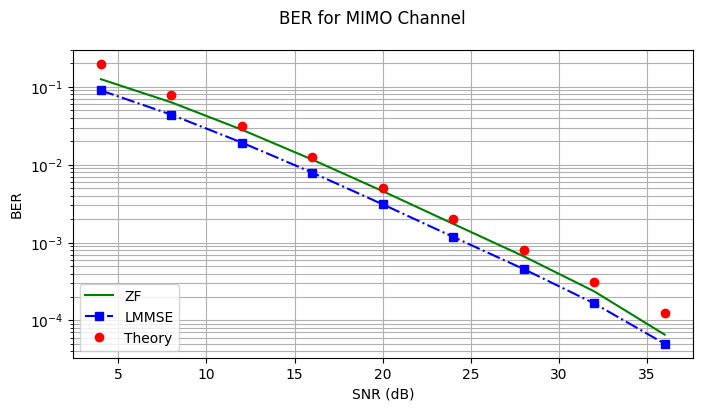

In [44]:
blockLength = 1000
nBlocks = 10000
r = 2
t = 2
EbdB = np.arange(1.0,33.1,4.0)
Eb = 10**(EbdB/10)
No = 1
Es = 2*Eb
SNR = Es/No
SNRdB = 10*np.log10(SNR)
BER_ZF = np.zeros(len(EbdB))
BER_LMMSE = np.zeros(len(EbdB))
BERt = np.zeros(len(EbdB))

for blk in range(nBlocks):
    H = (nr.normal(0.0, 1.0,(r,t)) + 1j*nr.normal(0.0, 1.0,(r,t)))/np.sqrt(2)
    noise = nr.normal(0.0, np.sqrt(No/2), (r,blockLength)) + 1j*nr.normal(0.0, np.sqrt(No/2), (r,blockLength))
    BitsI = nr.randint(2, size=(t, blockLength))
    BitsQ = nr.randint(2, size=(t, blockLength))
    Sym = (2*BitsI-1) +1j*(2*BitsQ-1)

    for K in range(len(SNRdB)):
        TxSym = np.sqrt(Eb[K])*Sym
        RxSym = np.matmul(H,TxSym) + noise

        ZFRx = nl.pinv(H)
        ZFout = np.matmul(ZFRx, RxSym)
        DecBitsI_ZF = (np.real(ZFout)>0)
        DecBitsQ_ZF = (np.imag(ZFout)>0)
        BER_ZF[K] = BER_ZF[K] + np.sum(DecBitsI_ZF != BitsI) + np.sum(DecBitsQ_ZF != BitsQ)

        LMMSERx = np.matmul(nl.inv(MIMO.AHA(H) + No*np.identity(t)/Es[K]),MIMO.H(H))
        LMMSEout = np.matmul(LMMSERx, RxSym)
        DecBitsI_LMMSE = (np.real(LMMSEout)>0)
        DecBitsQ_LMMSE = (np.imag(LMMSEout)>0)

        BER_LMMSE[K] = BER_LMMSE[K] + np.sum(DecBitsI_LMMSE != BitsI) + np.sum(DecBitsQ_LMMSE != BitsQ)

BER_ZF = BER_ZF/blockLength/nBlocks/2/t
BER_LMMSE = BER_LMMSE/blockLength/nBlocks/2/t
L=r-t+1
BERt = comb(2*L-1, L)/2**L/SNR**L

plt.figure(figsize=(8,4))
plt.yscale('log')
plt.plot(SNRdB, BER_ZF,'g-')
plt.plot(SNRdB, BER_LMMSE,'b-.s')
plt.plot(SNRdB, BERt,'ro')
plt.grid(1,which='both')
plt.suptitle('BER for MIMO Channel')
plt.legend(["ZF","LMMSE", "Theory"], loc ="lower left")
plt.xlabel('SNR (dB)')
plt.ylabel('BER')

## Task 2: MIMO Capacity for equal and optimal power allocation based on Waterfilling

Text(0, 0.5, 'Capacity (b/s/Hz)')

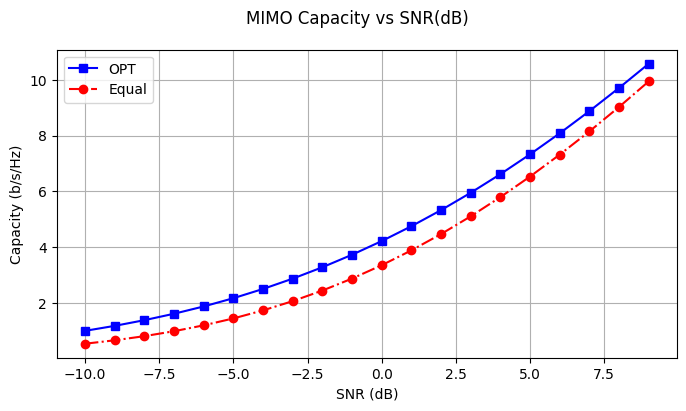

In [45]:
r = 4 
t = 4
SNRdB = np.arange(-10,10,1)
SNR = 10**(SNRdB/10)
numBlocks = 100; 
Capacity_OPT = np.zeros(len(SNRdB))
Capacity_EQ = np.zeros(len(SNRdB))

for L in range(numBlocks): 
    H = (nr.normal(0.0, 1.0,(r,t))+1j*nr.normal(0.0, 1.0,(r,t)))/np.sqrt(2)
    for kx in range(len(SNRdB)):   
        Capacity_OPT[kx] = Capacity_OPT[kx] + MIMO.OPT_CAP_MIMO(H, SNR[kx])
        Capacity_EQ[kx] += MIMO.EQ_CAP_MIMO(H, SNR[kx]);                                               

Capacity_OPT = Capacity_OPT/numBlocks
Capacity_EQ = Capacity_EQ/numBlocks

plt.figure(figsize=(8,4))
plt.plot(SNRdB,Capacity_OPT,'b-s')
plt.plot(SNRdB,Capacity_EQ,'r-.o')
plt.grid(1,which='both')
plt.legend(["OPT","Equal"], loc ="upper left")
plt.suptitle('MIMO Capacity vs SNR(dB)')
plt.xlabel('SNR (dB)')
plt.ylabel('Capacity (b/s/Hz)') 

## Task 3: Capacity of Massive MIMO channel with and without power scaling

Text(0.5, 0, 'Number of antennas M')

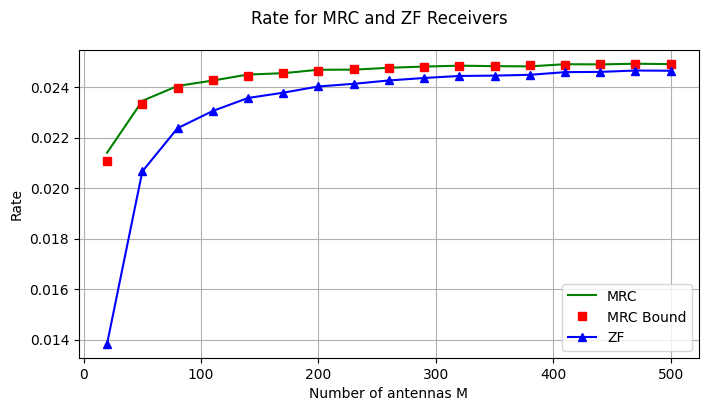

In [46]:
ITER = 3000
K = 10;                    ## number of users
Mv = np.arange(20,520,30); ## number of BS antennas
Eu_dB = 10;  Eu = 10**(Eu_dB/10)
rate_MRC = np.zeros(len(Mv)) 
bound_MRC = np.zeros(len(Mv))
rate_ZF = np.zeros(len(Mv))

beta = MIMO.Dmatrix(K);    ## Models the large scale fading of the channel gives a log normal RV
sqrtD = np.diag(np.sqrt(beta))

for it in range(ITER):
  for mx in range(len(Mv)):
    M = Mv[mx]
    pu = Eu/M # power scaling    ##pu = Eu # no power scaling
    H = (nr.normal(0, 1,(M,K)) + 1j*nr.normal(0, 1, (M,K)))/np.sqrt(2)
    G = np.matmul(H,sqrtD)       ## Contains both H info and Beta info. MxK matrix
    g0 = G[:,0];                 ## column user 0
    MRCbf = g0/nl.norm(g0)       ## beamforming vector
    nr_MRC = pu*nl.norm(g0)**2   ## numerator of the SINR
    nr_bound_MRC = pu*M*beta[0]
    dr_bound_MRC = 1
    mu_int = np.matmul(MIMO.H(MRCbf), G[:,1:])  # multi user interference of all the other channels except 0
    dr_MRC = 1 + pu * nl.norm(mu_int)**2        # noise power and the interference power
    dr_bound_MRC = dr_bound_MRC + pu*np.sum(beta[1:])
    rate_MRC[mx] = rate_MRC[mx] + np.log2(1 + nr_MRC/dr_MRC)  # calculating the capacity bits/sec/Hz
    bound_MRC[mx] = bound_MRC[mx] + np.log2(1 + nr_bound_MRC/dr_bound_MRC)

    GG = np.matmul(MIMO.H(G),G)
    nr_ZF = pu
    invGG = nl.inv(GG)
    dr_ZF = np.real(invGG[0,0])
    rate_ZF[mx] = rate_ZF[mx] + np.log2(1+nr_ZF/dr_ZF)

rate_MRC = rate_MRC/ITER
bound_MRC = bound_MRC/ITER
rate_ZF = rate_ZF/ITER

plt.figure(figsize=(8,4))
plt.plot(Mv, rate_MRC,'g-')
plt.plot(Mv, bound_MRC,'rs')
plt.plot(Mv, rate_ZF,'b^-')
plt.grid(1,which='both')
plt.legend(["MRC", "MRC Bound", "ZF"], loc ="lower right")
plt.suptitle('Rate for MRC and ZF Receivers')
plt.ylabel('Rate')
plt.xlabel('Number of antennas M')

### Without Power scaling

Text(0.5, 0, 'Number of antennas M')

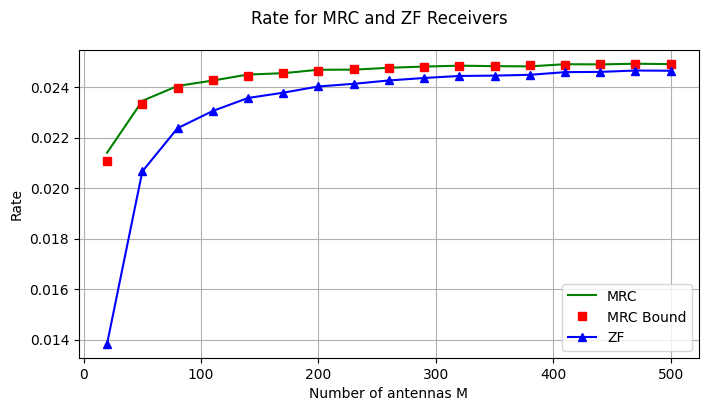

In [47]:
plt.figure(figsize=(8,4))
plt.plot(Mv, rate_MRC,'g-')
plt.plot(Mv, bound_MRC,'rs')
plt.plot(Mv, rate_ZF,'b^-')
plt.grid(1,which='both')
plt.legend(["MRC", "MRC Bound", "ZF"], loc ="lower right")
plt.suptitle('Rate for MRC and ZF Receivers')
plt.ylabel('Rate')
plt.xlabel('Number of antennas M')

## Task 4: Plotting the rate of a user (UL rate) when the BS has imperfect knowledge of channel(i.e. the channel is estimated)

Text(0.5, 0, 'Number of antennas M')

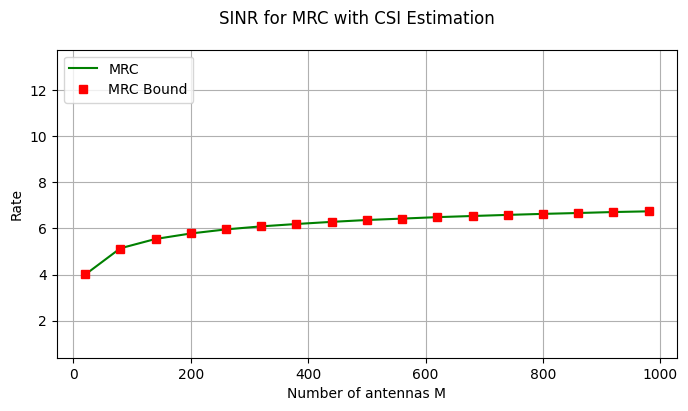

In [48]:
ITER = 2000
K = 10                      ## number of users
Mv = np.arange(20,1000,60); ## number of BS antennas
Eu_dB = 10;  Eu = 10**(Eu_dB/10)
rate_MRC = np.zeros(len(Mv)) 
bound_MRC = np.zeros(len(Mv))
rate_ZF = np.zeros(len(Mv))
beta = MIMO.Dmatrix(K);      ## large scale fading coefficients
sqrtD = np.diag(np.sqrt(beta))
dftmtx = MIMO.DFTmat(K)

for it in range(ITER):
  for mx in range(len(Mv)):
    M = Mv[mx]
    """
    pu = Eu   ## no power scaling
    pu = Eu/M ## power scaling
    """
    pu = Eu/np.sqrt(M)        ## modified powerscaling
    Pp = K*pu
    H = (nr.normal(size = (M,K)) + 1j * nr.normal(size = (M,K)))/np.sqrt(2)
    G = np.matmul(H,sqrtD)    ## Contains both H info and Beta info. MxK matrix
    g0 = G[:,0]               ## column of user 0
    Phi = np.sqrt(1/K)*dftmtx ## Pilot Matrix
    N = (nr.normal(size = (M,K)) + 1j * nr.normal(size = (M,K)))/np.sqrt(2)
    RxBlk = np.sqrt(Pp)*np.matmul(G,Phi) + N           ## Pilot Output
    Ghat = np.sqrt(1/Pp)*np.matmul(RxBlk, MIMO.H(Phi)) ## Channel Estimation
    g0hat = Ghat[:,0]
    e0 = g0hat - g0                                    ## Channel estimation error
    nr_MRC = pu*nl.norm(g0)**2
    nr_bound_MRC = pu*M*beta[0]
    dr_bound_MRC = 1/K + (beta[0] + 1/K/pu)/beta[0]
    g0norm = g0/nl.norm(g0)
    g0hat_norm = g0hat/nl.norm(g0)          ## should the den be g0hat
    CSIint = np.matmul(MIMO.H(g0norm),e0)
    CSIint = pu*np.abs(CSIint)**2           ## calculating the power due to channel interference error
    nint = nl.norm(g0hat)**2/nl.norm(g0)**2
    dr_MRC = CSIint + nint
    dr_bound_MRC = dr_bound_MRC + pu*np.sum((beta[0]+1/K/pu)*beta[1:]/beta[0])
    MUint = np.matmul(MIMO.H(g0hat_norm),G[:,1:])
    dr_MRC = dr_MRC + pu*nl.norm(MUint)**2
    rate_MRC[mx] = rate_MRC[mx] + np.log2(1 + nr_MRC/dr_MRC)
    bound_MRC[mx] += np.log2(1+nr_bound_MRC/dr_bound_MRC)  ## Note this is the theoretical lower bound

rate_MRC = rate_MRC/ITER
bound_MRC = bound_MRC/ITER

plt.figure(figsize=(8,4))
plt.plot(Mv, rate_MRC,'g-')
plt.plot(Mv, bound_MRC,'rs')
plt.grid(1,which='both')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0.1*y1,2*y2))
plt.legend(["MRC", "MRC Bound"], loc ="upper left")
plt.suptitle('SINR for MRC with CSI Estimation')
plt.ylabel('Rate')
plt.xlabel('Number of antennas M')

## Task 5: Spatial Modulation

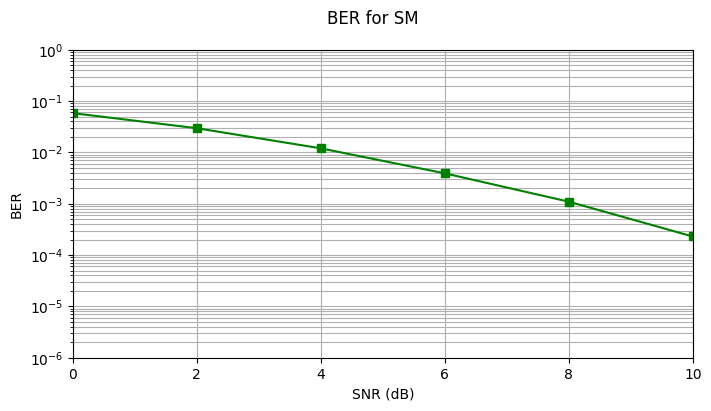

In [49]:
SNRdB = np.arange(0,11,2)
ITER = 100000
Nt = 4
Nr = 4
M = 2 # BPSK Modulation
bpcu = np.log2(M*Nt)
BERopt = np.zeros(len(SNRdB))
for ite in range(ITER):
  isym = nr.randint(2**bpcu)
  antIndex = isym % 4
  sym = 2 * (isym > 3) - 1
  H = 1/np.sqrt(2)*(nr.normal(0,1,(Nr,Nt)) + 1j*nr.normal(0,1,(Nr,Nt)))
  RxNoise = 1/np.sqrt(2)*(nr.normal(0,1,(Nr,1)) + 1j*nr.normal(0,1,(Nr,1)))
  for K in range(len(SNRdB)):
    rho = 10**(SNRdB[K]/10)
    RxVec = np.sqrt(rho)*H[:,antIndex:antIndex+1] * sym +RxNoise

    # Optimal detector
    MLobj = np.sum(np.absolute(np.sqrt(rho)*np.concatenate((-H,H),axis=1) - nm.repmat(RxVec, 1, 2*Nt))**2,axis=0)
    decIndex = np.argmin(MLobj)
    BERopt[K] = BERopt[K] + (decIndex != isym)

BERopt = BERopt/(bpcu*ITER)

plt.figure(figsize=(8,4))
plt.yscale('log')
plt.plot(SNRdB, BERopt,'gs-')
plt.grid(1,which='both')
plt.suptitle('BER for SM')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.xlim([0, 10])
plt.ylim([1e-6, 1])
plt.show()

## Task 6: Space Shift Keying

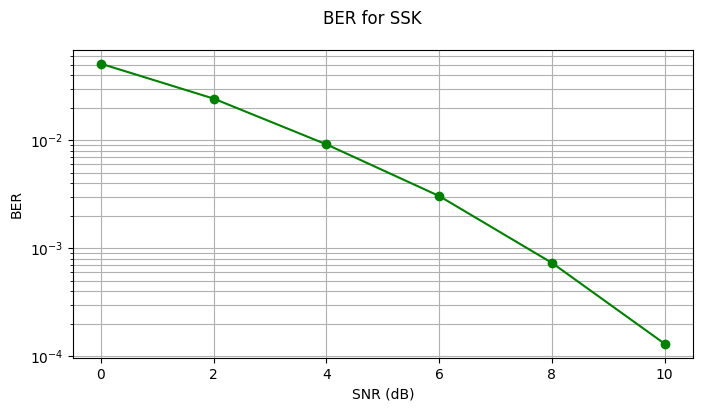

In [50]:
SNRdB = np.arange(0,11,2)
ITER = 100000
Nt = 4
Nr = 4
bpcu = np.log2(Nt)
BERopt = np.zeros(len(SNRdB))

for ite in range(ITER):
  antIndex = nr.randint(2**bpcu)
  H = 1/np.sqrt(2)*(nr.normal(0,1,(Nr,Nt)) + 1j*nr.normal(0,1,(Nr,Nt)))
  RxNoise = 1/np.sqrt(2)*(nr.normal(0,1,(Nr,1)) + 1j*nr.normal(0,1,(Nr,1)))
  for K in range(len(SNRdB)):
    rho = 10**(SNRdB[K]/10)
    RxVec = np.sqrt(rho)*H[:,antIndex:antIndex+1] + RxNoise

    # Optimal detector
    MLobj = np.sum(np.absolute(np.sqrt(rho)*H - nm.repmat(RxVec, 1, Nt))**2,axis=0)
    decIndex = np.argmin(MLobj)
    BERopt[K] = BERopt[K] + (decIndex != antIndex)
    
BERopt = BERopt/(bpcu*ITER)

plt.figure(figsize=(8,4))
plt.yscale('log')
plt.plot(SNRdB, BERopt,'go-')
plt.grid(1,which='both')
plt.suptitle('BER for SSK')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.show()